<a href="https://colab.research.google.com/github/TalhaOmi/-bengali-fake-news-using-bangla-bert-base/blob/main/(Main)_bengali_fake_news_using_bangla_bert_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install transformers
!pip install bnlp_toolkit
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 30.4 MB/s 
     |████████████████████████████████| 163 kB 63.3 MB/s 
     |████████████████████████████████| 6.6 MB 66.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.3 MB 45.9 MB/s 
     |████████████████████████████████| 23.9 MB 1.3 MB/s 
     |████████████████████████████████| 965 kB 54.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [5]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /60%/model_testing_auth.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment/Division /60%/model_testing_fake.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))

29208
780


In [6]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)



29988

In [7]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
বাংলাদেশের প্রশংসা করে শেখর ধাওয়ান বলেছেন, পাকিস্তান বড় নাম। কিন্তু কাগজে-কলমে লিখে দিলে তো সেটি হবে না। মাঠে যারা ভালো খেলবে তারাই বড় দল। আর বাংলাদেশ ভালো খেলেই ফাইনালে এসেছে। বৃহস্পতিবার ম্যাচপূর্ব সংবাদ সম্মেলনে এসব কথা বলেন এই ভারতীয় ওপেনার।  'বাংলাদেশকে এখন হারানো কঠিন। অনেকবার তারা নিজেদের প্রমাণ করেছে। সময়ের সঙ্গে তারা অভিজ্ঞ খেলোয়াড় পেয়েছে। তারা খেলা বোঝে। কৌশল বোঝে। চাপের ভেতর কীভাবে খেলতে হয় সেটা জানে। বাংলাদেশকে তারা সহজভাবে নিচ্ছেন না।' 'ফাইনালে আমরা আমাদের সর্বোচ্চটা দেয়ার চেষ্টা করবো। টুর্নামেন্টের প্রতিটি দল শক্তিশালী। অনেকেই ভেবেছিল ভারত-পাকিস্তান ফাইনাল হবে। কিন্তু দারুণ একটি ম্যাচ জিতে তারা এখানে এসেছে। আমরা বাংলাদেশকে সহজভাবে নিতে পারছি না।' বাংলাদেশ পাকিস্তানকে ৩৭ রানে হারিয়ে তৃতীয়বারের মতো এশিয়া কাপের ফাইনালে উঠেছে। শুক্রবার ধাওয়ানদের বিপক্ষে মাঠে নামবে তারা। ২০১৬ সালে এই দলের বিপক্ষেই ৮ উইকেটে হেরে রানার্সআপ হয় বাংলাদেশ। ধাওয়ান এবারের এশিয়া কাপে দারুণ ফর্মে রয়েছেন। হংকংয়ের বিপক্ষে প্রথম ম্যাচে সেঞ্চুরি (১২৭) করার পর দ্বিতীয় ম্যাচে

In [8]:
import imblearn

In [9]:
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler

In [10]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [11]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [12]:
x= df.drop('label', axis=1)
y= df.label

In [13]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [14]:
y_train_resampled

0       0
1       0
2       0
3       0
4       0
       ..
1555    1
1556    1
1557    1
1558    1
1559    1
Name: label, Length: 1560, dtype: int64

In [15]:
df = X_train_resampled.join(y_train_resampled)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  1560 non-null   int64 
 1   articleID   1560 non-null   int64 
 2   domain      1560 non-null   object
 3   date        1560 non-null   object
 4   category    1560 non-null   object
 5   headline    1560 non-null   object
 6   content     1560 non-null   object
 7   head        1560 non-null   object
 8   con         1560 non-null   object
 9   label       1560 non-null   int64 
dtypes: int64(3), object(7)
memory usage: 122.0+ KB


In [17]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [18]:
len(train_df), len(test_df)

(1248, 312)

In [19]:
test_df.head()

,Unnamed: 0,articleID,domain,date,category,headline,content,head,con,label
972,6508,8190,somoynews.tv,2018-09-22 13:54:27,Sports,পাকিস্তানের সঙ্গে পারলো না আফগানিস্তান,সুপার ফোরের শুরুতেই জয়ের দেখা পেয়েছে পাকিস্ত...,পাকিস্তানের পারলো আফগানিস্তান,সুপার ফোরের শুরুতেই জয়ের পেয়েছে পাকিস্তান আফগা...,1
512,80,82,motikontho.wordpress.com,2014-08-30T14:27:13+00:00,Miscellaneous,তেগের মানসিকতা লইয়া রাজনীতী করুন: আব্বাস | দৈন...,নিজস্ব মতিবেদকবৃহত্তর জামায়াতে ইসলামীর বিএনপি ...,তেগের মানসিকতা লইয়া রাজনীতী করুন আব্বাস দৈনিক ...,নিজস্ব মতিবেদকবৃহত্তর জামায়াতে ইসলামীর বিএনপি ...,0
1476,3970,4675,banglatribune.com,2018-09-21 06:37:19,National,চিড়িয়াখানা নাকি কারাগার?,ঢাকার মিরপুর চিড়িয়াখানার পর দেশের একমাত্র সরকা...,চিড়িয়াখানা কারাগার,ঢাকার মিরপুর চিড়িয়াখানার দেশের একমাত্র সরকারি ...,1
1396,11589,14616,channelionline.com,2018-09-24 21:06:15,International,সিরিয়াকে ক্ষেপণাস্ত্র দিচ্ছে রাশিয়া,সিরিয়াকে এস-৩০০ ভূমি থেকে আকাশে উৎক্ষেপণযোগ্য ...,সিরিয়াকে ক্ষেপণাস্ত্র দিচ্ছে রাশিয়া,সিরিয়াকে ৩০০ ভূমি আকাশে উৎক্ষেপণযোগ্য ক্ষেপণাস...,1
290,37,39,channeldhaka.news,2018-07-16T18:27:53+00:00,Miscellaneous,এইচএসসির ফলাফল ১৯জুলাই! পাশের হার ৪৮%!,এইচএসসি পরীক্ষায় এই বছর অংশগ্রহণকৃত ব্যাচটিকে...,এইচএসসির ফলাফল ১৯জুলাই পাশের হার ৪৮,এইচএসসি পরীক্ষায় বছর অংশগ্রহণকৃত ব্যাচটিকে আন...,0


In [20]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [21]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# Define Model
 `Bert` stands for Bidirectional Encoder Representations from Transformers used in this experiment with two additional `Fully Connected` Layers. 
 
 For this experiment, [Bangla Bert](https://huggingface.co/sagorsarker/bangla-bert-base) pretrained model was used.

#### FC layers
- First Linear Layer: IO(768 -> 128)
- Second Linear Layer: IO(128 -> 2)

#### Additionals
- Activation Fuction: Relu
- Dropout: 20%
- Optimizer: AdamW
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [22]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [23]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [24]:
# for param in bert.parameters():
#     param.requires_grad = False

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [26]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[-0.2520, -0.0199]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [27]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Lets Train

In [28]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [29]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [30]:
epochs = 2
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [31]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_main_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/2


  0%|          | 0/1248 [00:00<?, ?it/s]

	Train loss:0.853869.. 	Valid Loss:0.974458.. 	Accuracy: 80.4487
Epoch: 2/2


  0%|          | 0/1248 [00:00<?, ?it/s]

	Train loss:0.487186.. 	Valid Loss:0.862057.. 	Accuracy: 84.9359
Training completed in 4m 52s


In [32]:
training_acc1 = correct / total * 100
training_acc1

84.93589743589743

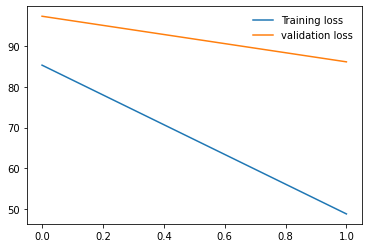

In [33]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [34]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_main_model1.pth", map_location = device))

<All keys matched successfully>

In [35]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [36]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.87      0.82      0.84       156
           1       0.83      0.88      0.85       156

    accuracy                           0.85       312
   macro avg       0.85      0.85      0.85       312
weighted avg       0.85      0.85      0.85       312



In [37]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


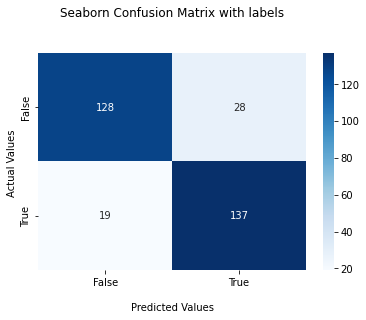

In [38]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [39]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy1 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy1)
precision = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision)
recall = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall)
score = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score)

Accuracy: 0.849
Precision: 0.851
Recall: 0.849
F-Measure: 0.849
